In [1]:
import pandas as pd 
import numpy as np
import math
from utlis import *


tmp = pd.read_csv('Weed_Resistance_Data.csv', sep = ',', header=None)
params_in = list(tmp[:21][0])


params_in = np.array(params_in)

In [2]:
General_TillingFrequency = np.loadtxt('Corteva/BMP_Matlab_Code/Tilling_Data.txt')
Herbicide_data = np.loadtxt('Corteva/BMP_Matlab_Code/Herbicide_Data.txt')

In [3]:
from utlis import PrepareParams
import numpy as np 
from scipy import integrate




a = 1
Params = PrepareParams()

nYears = int(Params.General.nYears)
nCohorts = int(Params.General.nCohorts)

# nYears = 25
# nCohorts = 2
print("starting year and cohort are: ", nYears, " & ", nCohorts)

H1_eff = [.5,.2,.01]
H2_eff = [0,0,0]
H3_eff = [0,0,0]
H4_eff = [0,0,0]

strategies = []
overall = []
risk_integral_all = []
seedbank_plot = []


for i in range(50):
    Population.seedBank = np.zeros((nYears,nGeno,nCohorts))
    # %Lower seed bank density
    Population.lowerBank = np.zeros((nYears,nGeno))
    # %immigrant seed
    Population.immSeed = np.zeros((nYears,nGeno,nCohorts))
    # %emigrant seed
    Population.emSeed = np.zeros((nYears,nGeno,nCohorts))
    # %germination storage
    Population.germination = np.zeros((nYears,nGeno,nCohorts))
    # %ungerminated storage
    Population.ungerminated = np.zeros((nYears,nGeno,nCohorts))
    Population.herbicide1 = np.zeros((nYears,nGeno,nCohorts))
    Population.herbicide2 = np.zeros((nYears,nGeno,nCohorts))
    Population.herbicide3 = np.zeros((nYears,nGeno,nCohorts))
    Population.herbicide4 = np.zeros((nYears,nGeno,nCohorts))
    Population.seedProd = np.zeros((nYears,nGeno,nCohorts))
    Population.mature = np.zeros((nYears,nGeno,nCohorts))
    Population.hand = np.zeros((nYears,nGeno,nCohorts))
    Population.immPol = np.zeros((nYears,nGeno,nCohorts))
    Population.emPol = np.zeros((nYears,nGeno,nCohorts))
    Population.newSeed = np.zeros((nYears,nGeno,nCohorts))
    Population.mutated = np.zeros((nYears,nGeno,nCohorts))
    Population.predation = np.zeros((nYears,nGeno,nCohorts))
    Population.winter = np.zeros((nYears,nGeno))
    Population.Res = np.zeros((1, 3))
    Population.seedBank[0,:,0] = Params.General.UpperSeedBank
    Population.lowerBank[0,:] = Params.General.LowerSeedBank

    for y in range(nYears):
        tempSeedBank = np.zeros(81)
        Population.seedBank[y,:,0],Population.lowerBank[y,:] = deepTill(Population.seedBank[y,:,0],
                                                                    Population.lowerBank[y,:],
                                                                    Params.General.TillingFreq,y)

        for c in range(nCohorts):
            # print(" y : ", y, " c", c)
            
            ImmSeed = seedImmigration(nGeno)
            seedBank = Population.seedBank[y,:,c]+ ImmSeed
            seedBank = extinction(seedBank,fieldSize)
            fGerm = Params.Germination.survivalFraction[0,0]
            germination = survival(seedBank,fGerm)
            ungerminated = seedBank - germination
            germination = extinction(germination,fieldSize)
            fCult = Params.Cultivation.survivalFraction[y,c]
            cult = survival(germination,fCult)
            cult = extinction(cult,fieldSize)

            # fSS = 1 - Params.Herbicide1.efficacy_SS[0,0]
            # fRS = 1 - Params.Herbicide1.efficacy_RS[0,0]
            # fRR = 1 - Params.Herbicide1.efficacy_RR[0,0]

            fSS = 1 - (H1_eff[0] + .011*nYears)
            fRS = 1 - (H1_eff[1] + .011*nYears)
            fRR = 1 - (H1_eff[2] + .011*nYears)

            targetLocus = Params.Herbicide1.targetLocus

            herbicide1_ = selectiveSurvival(cult,[fSS,fRS,fRR],targetLocus,Params.key)

            herbicide1 = extinction(herbicide1_,fieldSize)

            # fSS = 1 - Params.Herbicide2.efficacy_SS[y,c]
            # fRS = 1 - Params.Herbicide2.efficacy_RS[y,c]
            # fRR = 1 - Params.Herbicide2.efficacy_RR[y,c]

            fSS = 1 - H2_eff[0]
            fRS = 1 - H2_eff[1]
            fRR = 1 - H2_eff[2]

            targetLocus = Params.Herbicide2.targetLocus

            herbicide2 = selectiveSurvival(herbicide1,[fSS,fRS,fRR],targetLocus,Params.key)
                    
            herbicide2 = extinction(herbicide2,fieldSize)

            fSS = 1 - H3_eff[0]
            fRS = 1 - H3_eff[1]
            fRR = 1 - H3_eff[2]

            targetLocus = Params.Herbicide3.targetLocus

            herbicide3 = selectiveSurvival(herbicide2,[fSS,fRS,fRR],targetLocus,Params.key)
            herbicide3 = extinction(herbicide3,fieldSize)

            fSS = 1 - H4_eff[0]
            fRS = 1 - H4_eff[1]
            fRR = 1 - H4_eff[2]

            targetLocus = Params.Herbicide4.targetLocus

            herbicide4 = selectiveSurvival(herbicide3,[fSS,fRS,fRR],targetLocus,Params.key)
            herbicide4 = extinction(herbicide4,fieldSize)

            A = Params.Mature.maxplants[y,c]
            B = Params.Mature.cropParam[y,c]
            C = Params.Mature.weedCompetition[y,c]

            mature = competition(herbicide4,A,B,C)
            mature = extinction(mature,fieldSize)
            fHand = Params.Hand.survivalFraction[y,c]

            hand = survival(mature,fHand)
            hand = extinction(hand,fieldSize)
            
            A = Params.SeedProd.maxyield[y,c]
            B = Params.SeedProd.cropParam[y,c]
            C = Params.SeedProd.weedCompetition[y,c]

            sum_hand = float(np.sum(hand))
            seedYield = competition(sum_hand,A,B,C)
            
            newFrac = mating(hand,Params.General.selfingCoeff, Params.key)
            seedProd= newFrac*seedYield*Params.General.femaleFrac
            seedProd = extinction(seedProd,fieldSize)

            targetLocus = 1
            muS2R = Params.Mutation.muS2R_locus1[y,c]
            muR2S = Params.Mutation.muR2S_locus1[y,c]
        
            if muS2R==0 and muR2S==0:
                mutated_locus1 = seedProd
            else:
                mutated_locus1 = mutation(seedProd,muS2R,muR2S,targetLocus,Params.key)
                mutated_locus1 = extinction(mutated_locus1,fieldSize)

            targetLocus = 2
            muS2R = Params.Mutation.muS2R_locus2[y,c]
            muR2S = Params.Mutation.muR2S_locus2[y,c]

            if muS2R==0 and muR2S==0:
                mutated_locus2 = mutated_locus1
            else:
                mutated_locus2 = mutation(mutated_locus1,muS2R,muR2S,targetLocus,Params.key)
                mutated_locus2 = extinction(mutated_locus2,fieldSize)

            targetLocus = 3
            muS2R = Params.Mutation.muS2R_locus3[y,c]
            muR2S = Params.Mutation.muR2S_locus3[y,c]

            if muS2R==0 and muR2S==0:
                mutated_locus3 = mutated_locus2
            else:
                mutated_locus3 = mutation(mutated_locus2,muS2R,muR2S,targetLocus,Params.key)
                mutated_locus3 = extinction(mutated_locus3,fieldSize)

            targetLocus = 4
            muS2R = Params.Mutation.muS2R_locus4[y,c]
            muR2S = Params.Mutation.muR2S_locus4[y,c]

            if muS2R==0 and muR2S==0:
                mutated_locus4 = mutated_locus3
            else:
                mutated_locus4 = mutation(mutated_locus3,muS2R,muR2S,targetLocus,Params.key)
                mutated_locus4 = extinction(mutated_locus4,fieldSize)

            fPred = Params.Predation.survivalFraction[y,c]
            predation = survival(mutated_locus4,fPred)
            predation = extinction(predation,fieldSize)


            # print(predation) 
            if Params.General.seedDelay == 0:
                if c < nCohorts-1:
                    Population.seedBank[y,:,c+1] = Population.seedBank[y,:,c+1] + predation + ungerminated
                else:
                    tempSeedBank = tempSeedBank + ungerminated + predation
            else:
                tempSeedBank = tempSeedBank + predation
                if c < nCohorts:

                    Population.seedBank[y,:,c+1] = Population.seedBank[y,:,c+1] + ungerminated
                else:
                    tempSeedBank = tempSeedBank + ungerminated

            Population.immSeed[y,:,c] = ImmSeed
            Population.ungerminated[y,:,c] = ungerminated
            Population.germination[y,:,c] = germination
            Population.herbicide1[y,:,c] = herbicide1
            Population.herbicide2[y,:,c] = herbicide2
            # Population.herbicide3[y,:,c] = herbicide3
            # Population.herbicide4[y,:,c] = herbicide4
            Population.mature[y,:,c] = mature
            Population.hand[y,:,c] = hand
            Population.seedProd[y,:,c] = seedProd
            Population.predation[y,:,c] = predation
            
        if y != nYears-1:
            fWint_upper = Params.Winter.uppersurvivalFraction[y][c]
            fWint_lower = Params.Winter.lowersurvivalFraction[y][c]

            winter_ = survival(tempSeedBank,fWint_upper)
            winter = extinction(winter_,fieldSize)

            Population.winter[y,:] = winter
            Population.seedBank[y+1,:,0] = Population.seedBank[y+1,:,0] + winter
            Population.lowerBank[y+1,:] = survival(Population.lowerBank[y,:],fWint_lower)
            Population.lowerBank[y+1,:] = extinction(Population.lowerBank[y+1,:],fieldSize)

        else:
            break
        N = nYears*nCohorts

    newPop = np.zeros((N,nGeno))

    k = 0
    for y in range(nYears):
        for c in range(nCohorts):
            newPop[k,:] = Population.seedBank[y,:,c]
            k = k + 1


    Rpop = np.zeros(nYears*nCohorts,)
    for G in range(nGeno):
        for L in range(nLoci):
            if Params.key[L,G] == 2 or Params.key[L,G] == 1:
                Rpop =  Rpop + newPop[:,G]
                break
            
    pltPop = Rpop/np.sum(newPop, axis=1)
    # print(pltPop.shape)

    if sum(pltPop[-5:-1]) > .2:
        strategies.append(pltPop)
        overall.append(pltPop)
        seedbank_plot.append(np.sum(newPop, axis=1))
        risk_integral_all.append(integrate.trapezoid(pltPop)/N)
        
        a+=1
        if a % 20 == 0 or i == 999:
            print("total fish caught: ", a)
    else:
        overall.append(pltPop)
        risk_integral_all.append(integrate.trapezoid(pltPop)/N)
        seedbank_plot.append(np.sum(newPop, axis=1))




starting year and cohort are:  25  &  2


In [4]:
a

15

In [5]:
np.mean([i for i in risk_integral_all])

0.11741967884059103

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
strategies = seedbank_plot

strategies = np.array(strategies)
strategy = np.mean(strategies, axis=0)

dev = np.std(strategies, axis = 0)



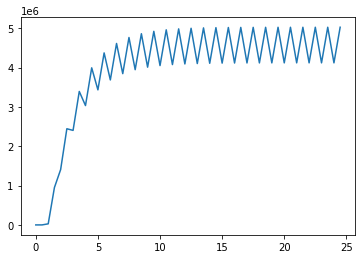

In [7]:
x = np.array([i for i in range(len(strategy))])/nCohorts



plt.plot(x,np.sum(newPop, axis=1))
# plt.plot(x,y)


In [8]:
# len(risk_integral_all)
strategy

array([1.00000000e+00, 2.01093145e+02, 2.73350315e+04, 9.51256448e+05,
       1.40743083e+06, 2.44607580e+06, 2.40425118e+06, 3.39487801e+06,
       3.03570560e+06, 3.99530847e+06, 3.43519299e+06, 4.37507604e+06,
       3.68784316e+06, 4.61523553e+06, 3.84761106e+06, 4.76710175e+06,
       3.94864106e+06, 4.86313589e+06, 4.01252920e+06, 4.92386648e+06,
       4.05293222e+06, 4.96227470e+06, 4.07848586e+06, 4.98656923e+06,
       4.09465109e+06, 5.00194126e+06, 4.10488162e+06, 5.01167413e+06,
       4.11136196e+06, 5.01784466e+06, 4.11547379e+06, 5.02176604e+06,
       4.11809043e+06, 5.02426757e+06, 4.11976294e+06, 5.02587179e+06,
       4.12083819e+06, 5.02690726e+06, 4.12153426e+06, 5.02758072e+06,
       4.12198859e+06, 5.02802295e+06, 4.12228841e+06, 5.02831736e+06,
       4.12248950e+06, 5.02851746e+06, 4.12262768e+06, 5.02865749e+06,
       4.12272571e+06, 5.02875891e+06])

In [9]:
result_dict = {}
avg_std = {}
avg_std['average'] = strategy
avg_std['std'] = dev

# molecule = {}

# dose = {}

# dose['combined'] = avg_std

# molecule['x713'] = dose





import pickle as pkl
# create a binary pickle file 
# f = open("x713_25_50.pkl","wb")
# f = pkl.load( open( "x755_50_pop.pkl", "rb" ) )

result_dict['x755_50_chohort_2'] = avg_std
## write the python object (dict) to pickle file
pkl.dump( result_dict, open( "x755_50_pop_cohort_2.pkl", "wb" ) )

# close file
# f.close()







In [10]:
f = pkl.load( open( "x755_50_pop.pkl", "rb" ) )
f

{'x755_50': {'average': array([1.00000000e+00, 1.40760800e+02, 1.93344479e+04, 6.18222017e+05,
         1.18354857e+06, 1.56279606e+06, 1.81588300e+06, 1.98457846e+06,
         2.09697383e+06, 2.17184649e+06, 2.22172241e+06, 2.25494957e+06,
         2.27708866e+06, 2.29184278e+06, 2.30167770e+06, 2.30823538e+06,
         2.31260936e+06, 2.31552805e+06, 2.31747677e+06, 2.31877896e+06,
         2.31965024e+06, 2.32023442e+06, 2.32062743e+06, 2.32089321e+06,
         2.32107434e+06]),
  'std': array([0.00000000e+00, 7.15165511e-02, 3.13115563e+01, 6.51049984e+02,
         4.93293815e+02, 3.84932172e+02, 3.27874004e+02, 3.13196641e+02,
         3.33520258e+02, 3.82613657e+02, 4.54286824e+02, 5.41836518e+02,
         6.38243515e+02, 7.36879220e+02, 8.32287409e+02, 9.20646770e+02,
         9.99772634e+02, 1.06883747e+03, 1.12796400e+03, 1.17786847e+03,
         1.21958556e+03, 1.25431555e+03, 1.28335298e+03, 1.30803402e+03,
         1.32965439e+03])}}

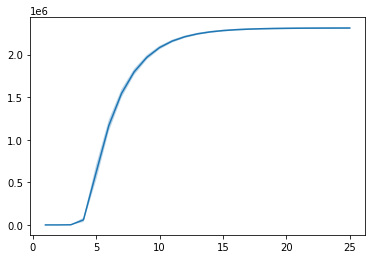

In [9]:
lower = strategy - dev
upper = strategy + dev 



plt.fill_between([x+1 for x in range(len(strategy))], lower, upper, alpha=.3)
plt.plot([x+1 for x in range(len(strategy))], strategy)
# plt.ylim([-0.10,1.1])